# Spot Existence Prediction for Real Light Curves

This notebook demonstrates how to predict the existence of spots in real light curve data using pretrained models. It uses already transformed images from the `real_lc/images_hex` directory and selects the appropriate model based on the system type (detached or overcontact) and passband. At the end the metrics are calculated.

# !Attention!
To use this notebook you need to download models and images

1. Go to the storage [link](https://u.pcloud.link/publink/show?code=kZMm285Zoy7Q3IAQOakIshhv4jTeH8OAtS4y#/filemanager?folder=25535342132)
2. Select the folders **Models** and **SelectedLC** and download them
3. Unzip the downloaded files
4. From each directory in the unzipped **Models** folder, copy all `.pth` files to the `models` directory
5. Copy the **SelectedLC** folder to the `data` directory and rename it to **real_lc**

*If you see `2class_binary_resnet_gaia_hexbin_20250620.pth` file, that means we forgot to delete it. Please, do it yourself. You will not need it.*

*Please, if there is still `2class_detspot_resnet_gaia_hexbinre.pth` file rename it to `2class_detachspot_resnet_gaia_hexbin.pth`*


## 1. Setup: Import Libraries and Define Paths
We will import the necessary libraries and set up paths to the image directory and models.

In [1]:
import os
import glob
import pandas as pd
import sys
sys.path.append('../scripts')
from classify_pytorch_resnet import load_resnet_model, predict_image
from classify_pytorch_vit import load_vit_model, predict_image_vit

## 2. Define Helper Functions
We will define a helper function to select the correct model for spot prediction based on the system type and passband.

In [2]:
def get_spot_resnet_model(system_type, passband):
    """
    Returns the path to the correct spot detection model for the given system type and passband.
    """
    if system_type == 'detached' and passband == 'gaia':
        return '../models/2class_detachspot_resnet_gaia_hexbin.pth'
    elif system_type == 'overcontact' and passband == 'gaia':
        return '../models/2class_overspot_resnet_gaia_hexbin.pth'
    elif system_type == 'detached' and passband == 'tess':
        return '../models/2class_detachspot_resnet_TESS_hexbin.pth'
    elif system_type == 'overcontact' and passband == 'tess':
        return '../models/2class_overspot_resnet_TESS_hexbin.pth'
    # Add more conditions for other passbands if needed
    else:
        raise ValueError(f"No model for system_type={system_type}, passband={passband}")

def get_spot_vit_model(system_type, passband):
    """
    Returns the path to the correct ViT spot detection model for the given system type and passband.
    """
    if system_type == 'detached' and passband == 'gaia':
        return '../models/2class_detachspot_ViT_gaia_hexbin.pth'
    elif system_type == 'overcontact' and passband == 'gaia':
        return '../models/2class_overspot_ViT_gaia_hexbin.pth'
    elif system_type == 'detached' and passband == 'tess':
        return '../models/2class_detachspot_ViT_TESS_hexbin.pth'
    elif system_type == 'overcontact' and passband == 'tess':
        return '../models/2class_overspot_ViT_TESS_hexbin.pth'
    else:
        raise ValueError(f"No ViT model for system_type={system_type}, passband={passband}")
    
def extract_object_name(filename, system_type, passband):
    base = os.path.basename(filename)
    if passband == 'gaia':
        # Both detached and overcontact: name is before the last underscore (object name may contain spaces)
        # e.g. 'AI_Hya_3077483709857255808_p.png' or '1SWASP J034501.24+493659.9_249570280308984064_p.png'
        return '_'.join(base.split('_')[:-2])
    elif passband == 'tess':
        # e.g. 'tess_lc_AD_Boo_tess_jdmin.png' or 'tess_lc_1SWASP J034501.24+493659.9_tess_jdmin.png'
        s = base.replace('.png','')
        if s.startswith('tess_lc_') and s.endswith('_tess_jdmin'):
            name = s[len('tess_lc_'):-len('_tess_jdmin')]
            return name
        else:
            # fallback: try to extract between first and last underscore
            parts = s.split('_')
            if len(parts) > 3:
                return '_'.join(parts[2:-2])
            else:
                return s
    else:
        return base.replace('.png','')

# get image path for a given object, system type, and passband

def get_image_path(object_name, system_type, passband):
    folder = f'{"GAIA" if passband=="gaia" else "TESS"}_{"DEB" if system_type=="detached" else "WUMaCat"}'
    folder_path = os.path.join(image_dir, folder, 'Images_hex')
    for img_file in glob.glob(os.path.join(folder_path, '*.png')):
        if extract_object_name(img_file, system_type, passband) == object_name:
            return img_file
    return None

def get_object_names_from_folder(folder_path, system_type, passband):
    names = set()
    for img_file in glob.glob(os.path.join(folder_path, '*.png')):
        name = extract_object_name(img_file, system_type, passband)
        names.add(name)
    return names

## 3. Consistency Check Between TESS and Gaia Folders
This cell checks if the number of objects and their names are consistent between TESS and Gaia folders for both detached and overcontact systems. It reports the counts and any unique object names in each set.

In [3]:
# Directory containing images
image_dir = '../data/real_lc/'

# Find objects present in both GAIA and TESS for each system type
overcontact_common = sorted(
    get_object_names_from_folder(
        os.path.join(image_dir, 'GAIA_WUMaCat', 'Images_hex'), 'overcontact', 'gaia'
    ) & get_object_names_from_folder(
        os.path.join(image_dir, 'TESS_WUMaCat', 'Images_hex'), 'overcontact', 'tess'
    )
)

detached_common = sorted(
    get_object_names_from_folder(
        os.path.join(image_dir, 'GAIA_DEB', 'Images_hex'), 'detached', 'gaia'
    ) & get_object_names_from_folder(
        os.path.join(image_dir, 'TESS_DEB', 'Images_hex'), 'detached', 'tess'
    )
)

print("Overcontact objects in both GAIA and TESS:", overcontact_common)
print("Detached objects in both GAIA and TESS:", detached_common)


Overcontact objects in both GAIA and TESS: ['1SWASP J034501.24+493659.9', '1SWASP J093010.78+533859.5', '1SWASP J150822.80-054236.9', '1SWASP J160156.04+202821.6', 'AA UMa', 'AC Boo', 'AD Phe', 'AG Vir', 'AH Aur', 'AK Her', 'AM Leo', 'AO Cam', 'AQ Psc', 'AQ Tuc', 'AU Ser', 'BB Peg', 'BD +42 2782', 'BI CVn', 'BN Ari', 'BX And', 'BX Peg', 'CN And', 'CT Eri', 'DK Cyg', 'DN Boo', 'DN Cam', 'DU Boo', 'DX Tuc', 'DZ Psc', 'EE Cet', 'EF Boo', 'EF Dra', 'EL Aqr', 'ET Leo', 'EX Leo', 'EZ Hya', 'FN Cam', 'FP Boo', 'FT Lup', 'GZ And', 'HH Boo', 'HI Pup', 'II UMa', 'KIC 10618253', 'KIC 9832227', 'LO And', 'MW Pav', 'NN Vir', 'PY Vir', 'QW Gem', 'RR Cen', 'RT LMi', 'RZ Com', 'RZ Tau', 'SS Ari', 'SX Crv', 'SZ Hor', 'TT Cet', 'TV Mus', 'TW Cet', 'TX Cnc', 'TY Pup', 'TYC 2675-663-1', 'UX Eri', 'UZ Leo', 'V1073 Cyg', 'V1128 Tau', 'V1191 Cyg', 'V1918 Cyg', 'V2150 Cyg', 'V357 Peg', 'V376 And', 'V402 Aur', 'V404 Peg', 'V410 Aur', 'V417 Aql', 'V546 And', 'V592 Per', 'V728 Her', 'V839 Oph', 'V842 Her', 'V868

## 4. Predict Spot Existence Only for Common Objects in Both Passbands
This cell predicts spot existence for objects present in both TESS and Gaia (using the lists `overcontact_common` and `detached_common`). For each object, predictions from ResNet and ViT in both passbands are written in a single row of the resulting DataFrame.

*The next code cell could execute quite long, it depends on if you have GPU or how fast is your CPU.*


In [5]:
# Predict for a list of objects, system type, and write all results in one row

def predict_spots_for_common(common_list, system_type):
    results = []
    for object_name in common_list:
        row = {'object': object_name}
        for passband in ['gaia', 'tess']:
            img_path = get_image_path(object_name, system_type, passband)
            if img_path is None:
                # If image is missing, fill with None
                row[f'spots_{passband}_resnet'] = None
                row[f'spot_probability_{passband}_resnet'] = None
                row[f'spots_{passband}_vit'] = None
                row[f'spot_probability_{passband}_vit'] = None
                continue
            # ResNet
            resnet_model_path = get_spot_resnet_model(system_type, passband)
            resnet_model = load_resnet_model(resnet_model_path, num_classes=2)
            spot_class_r, spot_probs_r = predict_image(resnet_model, img_path)
            spot_label_r = 'n' if spot_class_r == 0 else 's'
            spot_prob_r = spot_probs_r[spot_class_r]
            row[f'spots_{passband}_resnet'] = spot_label_r
            row[f'spot_probability_{passband}_resnet'] = spot_prob_r
            # ViT
            vit_model_path = get_spot_vit_model(system_type, passband)
            vit_model = load_vit_model(vit_model_path, num_classes=2)
            spot_class_v, spot_probs_v = predict_image_vit(vit_model, img_path)
            spot_label_v = 'n' if spot_class_v == 0 else 's'
            spot_prob_v = spot_probs_v[spot_class_v]
            row[f'spots_{passband}_vit'] = spot_label_v
            row[f'spot_probability_{passband}_vit'] = spot_prob_v
        results.append(row)
    return pd.DataFrame(results)

# Predict for detached and overcontact common objects
spot_df_detached = predict_spots_for_common(detached_common, 'detached')
spot_df_overcontact = predict_spots_for_common(overcontact_common, 'overcontact')

display(spot_df_detached)
display(spot_df_overcontact)

,object,spots_gaia_resnet,spot_probability_gaia_resnet,spots_gaia_vit,spot_probability_gaia_vit,spots_tess_resnet,spot_probability_tess_resnet,spots_tess_vit,spot_probability_tess_vit
0,AH_Cep,s,0.933016,n,0.865449,s,0.997490,n,0.910393
1,AI_Hya,n,0.850407,n,0.840156,n,0.904362,n,0.566531
2,AR_Aur,n,0.916470,n,0.852681,n,0.845662,n,0.910412
3,BG_Ind,n,0.901698,n,0.883139,s,0.768125,n,0.889714
4,CC_Cas,n,0.674897,n,0.883884,n,0.639576,n,0.755849
5,CV_Vel,n,0.955394,n,0.855049,n,0.721957,n,0.701111
6,CW_Cep,n,0.889655,n,0.897147,s,0.925610,n,0.804729
7,CW_Eri,n,0.874224,n,0.846903,s,0.508793,n,0.781678
8,DI_Her,n,0.853270,n,0.857909,s,0.792952,n,0.683459
9,EE_Peg,n,0.882563,n,0.856864,n,0.917641,n,0.780116


,object,spots_gaia_resnet,spot_probability_gaia_resnet,spots_gaia_vit,spot_probability_gaia_vit,spots_tess_resnet,spot_probability_tess_resnet,spots_tess_vit,spot_probability_tess_vit
0,1SWASP J034501.24+493659.9,s,0.652131,s,0.742039,s,0.794934,s,0.559963
1,1SWASP J093010.78+533859.5,s,0.924441,s,0.770622,s,0.999957,s,0.878430
2,1SWASP J150822.80-054236.9,s,0.904219,s,0.779291,n,0.703670,n,0.569780
3,1SWASP J160156.04+202821.6,s,0.999999,s,0.718879,s,0.993757,s,0.987178
4,AA UMa,n,0.768505,s,0.802301,n,0.521665,n,0.546446
...,...,...,...,...,...,...,...,...,...
85,V972 Her,s,0.513010,s,0.541050,s,0.955581,n,0.542566
86,VW Boo,s,0.973582,s,0.564417,s,0.992466,s,0.975731
87,VW LMi,s,0.925584,s,0.601370,s,0.797238,s,0.567535
88,W UMa,s,0.799906,s,0.853752,s,0.515093,s,0.989062


The above tables show spot predictions for all common objects in both passbands, with results from both ResNet and ViT models in each row.

In [6]:
# Load the WUMaCat catalog with real spot labels
wumacat = pd.read_csv('../data/classification_WUMaCat.csv')

# Make sure the 'name' column matches the 'object' column in spot_df_overcontact
# If needed, strip whitespace for robust matching
wumacat['name'] = wumacat['name'].astype(str).str.strip()
spot_df_overcontact['object'] = spot_df_overcontact['object'].astype(str).str.strip()

# Merge real spot labels into the predictions DataFrame
# Assume the real spot column in the catalog is named 'spot' (change if needed)
spot_df_overcontact = spot_df_overcontact.merge(
    wumacat[['name', 'real_spot']].rename(columns={'name': 'object', 'real_spot': 'real_spot'}),
    on='object',
    how='left'
)

display(spot_df_overcontact)

,object,spots_gaia_resnet,spot_probability_gaia_resnet,spots_gaia_vit,spot_probability_gaia_vit,spots_tess_resnet,spot_probability_tess_resnet,spots_tess_vit,spot_probability_tess_vit,real_spot
0,1SWASP J034501.24+493659.9,s,0.652131,s,0.742039,s,0.794934,s,0.559963,s
1,1SWASP J093010.78+533859.5,s,0.924441,s,0.770622,s,0.999957,s,0.878430,s
2,1SWASP J150822.80-054236.9,s,0.904219,s,0.779291,n,0.703670,n,0.569780,s
3,1SWASP J160156.04+202821.6,s,0.999999,s,0.718879,s,0.993757,s,0.987178,s
4,AA UMa,n,0.768505,s,0.802301,n,0.521665,n,0.546446,s
...,...,...,...,...,...,...,...,...,...,...
85,V972 Her,s,0.513010,s,0.541050,s,0.955581,n,0.542566,n
86,VW Boo,s,0.973582,s,0.564417,s,0.992466,s,0.975731,s
87,VW LMi,s,0.925584,s,0.601370,s,0.797238,s,0.567535,s
88,W UMa,s,0.799906,s,0.853752,s,0.515093,s,0.989062,s


In [7]:
# Save the overcontact spot prediction DataFrame to CSV
spot_df_overcontact.to_csv('../data/spot_df_overcontact_predictions.csv', index=False)
print('Saved spot_df_overcontact to ../data/spot_df_overcontact_predictions.csv')

Saved spot_df_overcontact to ../data/spot_df_overcontact_predictions.csv


In [8]:
# Load the DEBcat catalog with real spot labels for detached systems
# (Assume the file is named 'classification_DEBcat.csv' and has columns 'name' and 'real_spot')
debcat = pd.read_csv('../data/classification_DEBcat.csv')

debcat['name'] = debcat['name'].astype(str).str.strip()
spot_df_detached['object'] = spot_df_detached['object'].astype(str).str.strip()

# Merge real spot labels into the predictions DataFrame
spot_df_detached = spot_df_detached.merge(
    debcat[['name', 'real_spot']].rename(columns={'name': 'object', 'real_spot': 'real_spot'}),
    on='object',
    how='left'
)

display(spot_df_detached)

# Save the detached spot prediction DataFrame to CSV
spot_df_detached.to_csv('../data/spot_df_detached_predictions.csv', index=False)
print('Saved spot_df_detached to ../data/spot_df_detached_predictions.csv')

,object,spots_gaia_resnet,spot_probability_gaia_resnet,spots_gaia_vit,spot_probability_gaia_vit,spots_tess_resnet,spot_probability_tess_resnet,spots_tess_vit,spot_probability_tess_vit,real_spot
0,AH_Cep,s,0.933016,n,0.865449,s,0.997490,n,0.910393,n
1,AI_Hya,n,0.850407,n,0.840156,n,0.904362,n,0.566531,s
2,AR_Aur,n,0.916470,n,0.852681,n,0.845662,n,0.910412,n
3,BG_Ind,n,0.901698,n,0.883139,s,0.768125,n,0.889714,s
4,CC_Cas,n,0.674897,n,0.883884,n,0.639576,n,0.755849,n
5,CV_Vel,n,0.955394,n,0.855049,n,0.721957,n,0.701111,s
6,CW_Cep,n,0.889655,n,0.897147,s,0.925610,n,0.804729,n
7,CW_Eri,n,0.874224,n,0.846903,s,0.508793,n,0.781678,n
8,DI_Her,n,0.853270,n,0.857909,s,0.792952,n,0.683459,n
9,EE_Peg,n,0.882563,n,0.856864,n,0.917641,n,0.780116,n


Saved spot_df_detached to ../data/spot_df_detached_predictions.csv


## 5. Import and Use spot_metrics Functions

The following cells import the metric and plotting functions from `scripts/spot_metrics.py` and apply them to the prediction of spot existence results for both overcontact and detached systems.


Metrics for Overcontact systems:


,Model/Passband,Accuracy,Precision,Recall,F1-score,TN,FP,FN,TP
0,spots_gaia_resnet,0.60,0.63,0.52,0.57,30,14,22,24
1,spots_tess_resnet,0.50,0.51,0.83,0.63,7,37,8,38
2,spots_gaia_vit,0.53,0.52,1.00,0.69,2,42,0,46
3,spots_tess_vit,0.49,0.50,0.76,0.60,9,35,11,35



Metrics for Detached systems:


,Model/Passband,Accuracy,Precision,Recall,F1-score,TN,FP,FN,TP
0,spots_gaia_resnet,0.63,0.42,0.29,0.34,28,7,12,5
1,spots_tess_resnet,0.62,0.43,0.59,0.50,22,13,7,10
2,spots_gaia_vit,0.67,0.00,0.00,0.00,35,0,17,0
3,spots_tess_vit,0.63,0.00,0.00,0.00,33,2,17,0



AUC for Overcontact systems:


,Model/Passband,AUC
0,spot_probability_gaia_resnet,0.645
1,spot_probability_tess_resnet,0.593
2,spot_probability_gaia_vit,0.603
3,spot_probability_tess_vit,0.606



AUC for Detached systems:


,Model/Passband,AUC
0,spot_probability_gaia_resnet,0.534
1,spot_probability_tess_resnet,0.546
2,spot_probability_gaia_vit,0.516
3,spot_probability_tess_vit,0.360


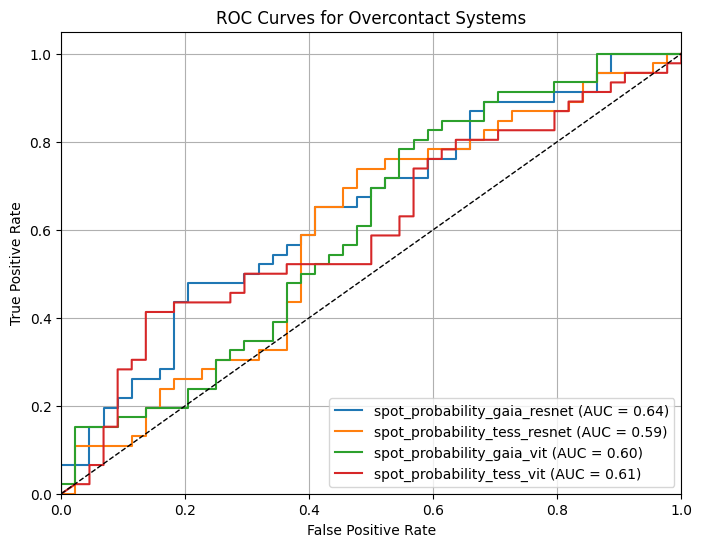

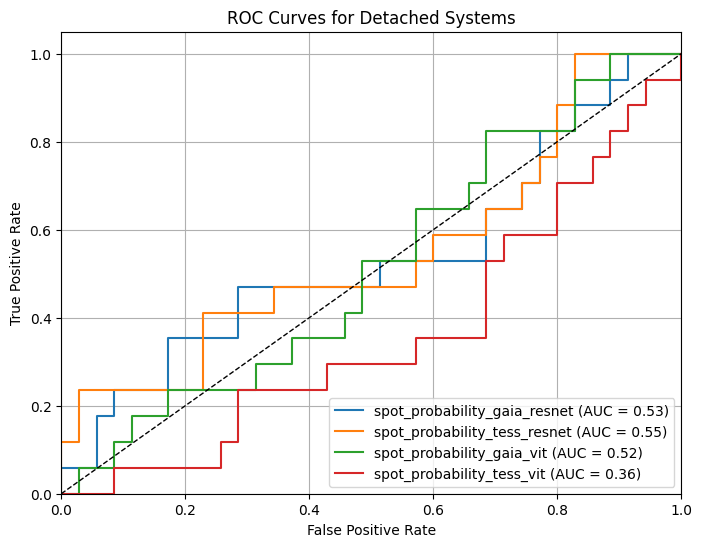

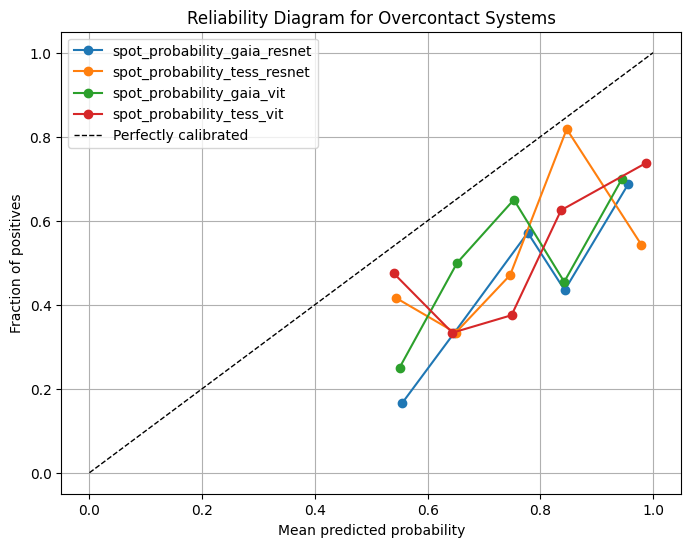

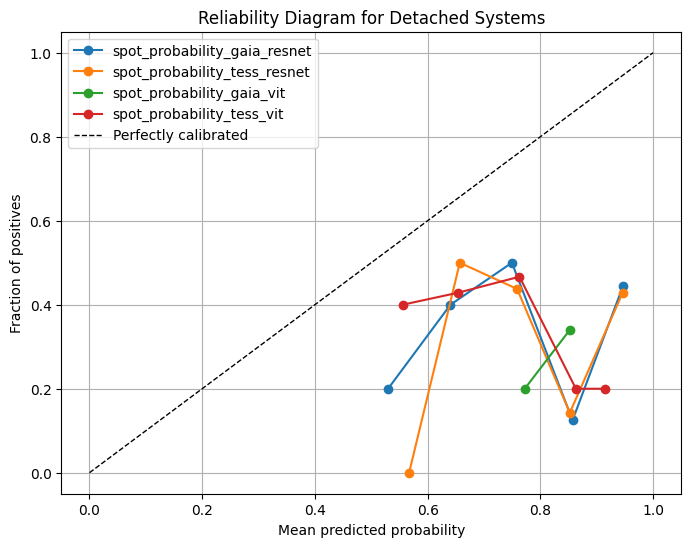

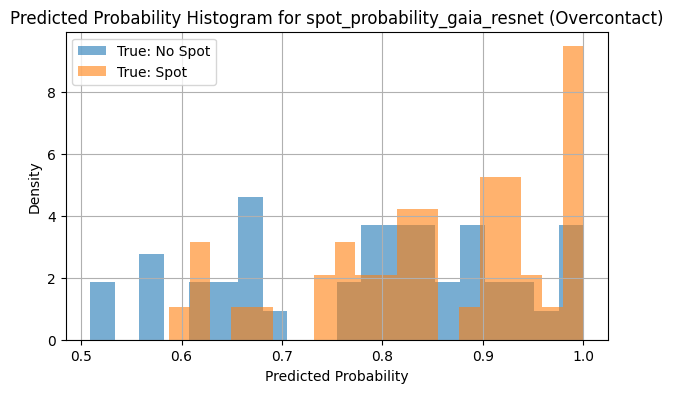

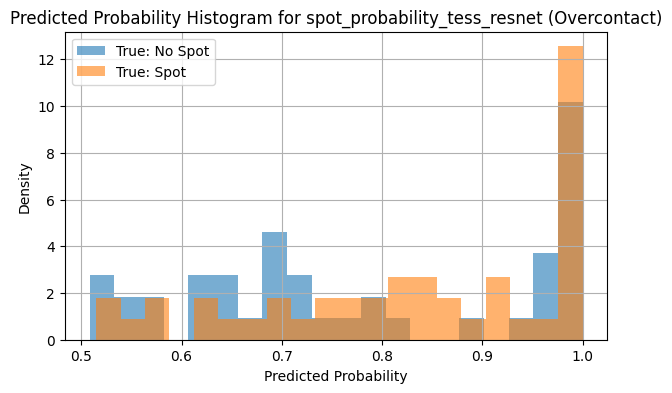

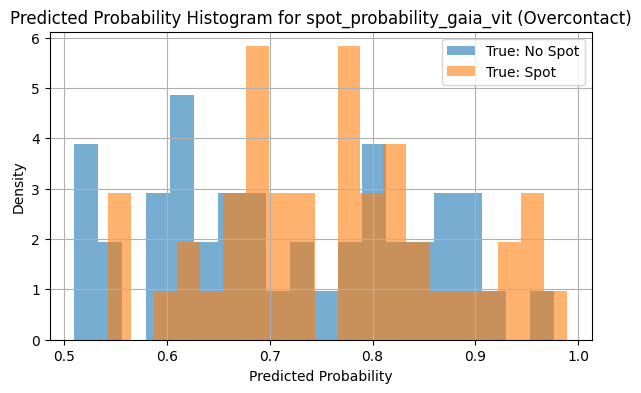

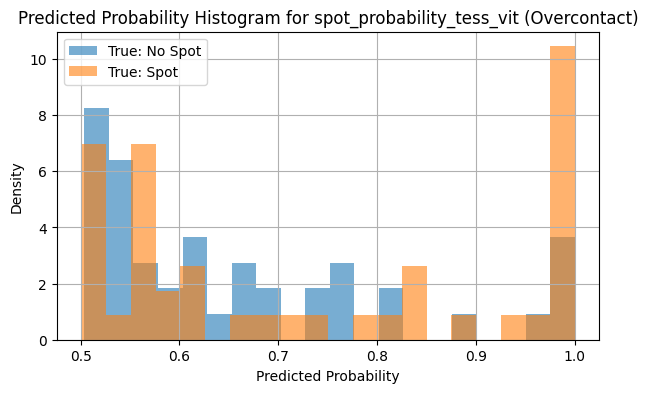

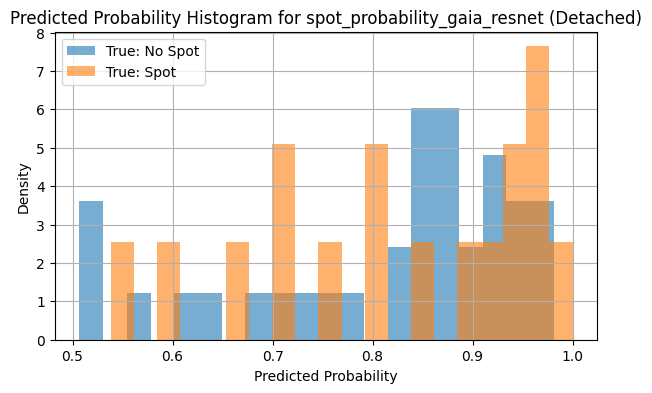

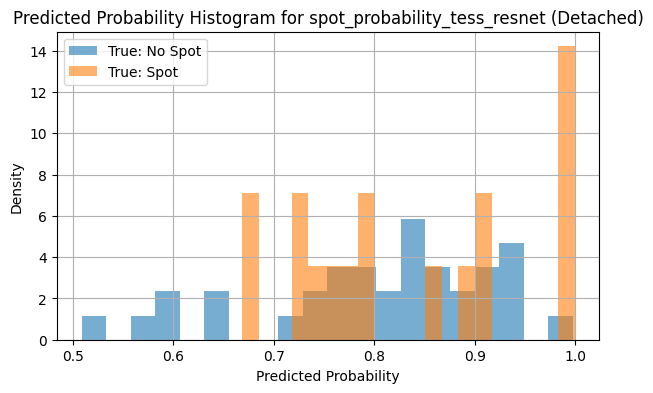

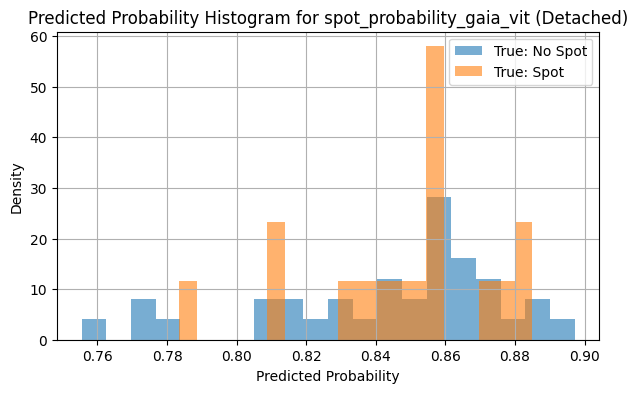

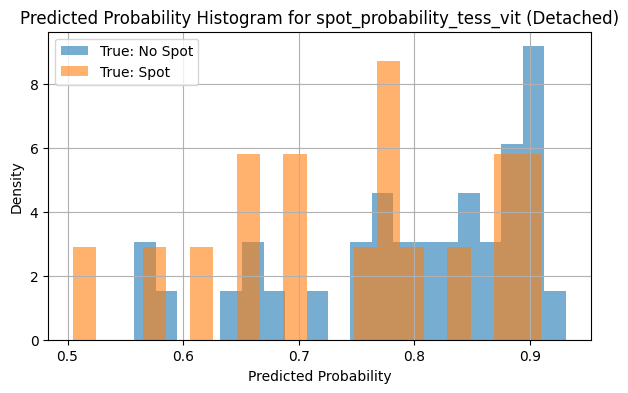

In [9]:
# Import spot_metrics functions and calculate metrics for both system types
import sys
sys.path.append('../scripts')
from spot_metrics import print_metrics_table, print_auc_table, plot_roc_curves, plot_reliability_diagram, plot_probability_histograms
from IPython.display import display

# Define prediction and probability columns
pred_cols = [
    'spots_gaia_resnet', 'spots_tess_resnet',
    'spots_gaia_vit', 'spots_tess_vit'
]
prob_cols = [
    'spot_probability_gaia_resnet', 'spot_probability_tess_resnet',
    'spot_probability_gaia_vit', 'spot_probability_tess_vit'
]

# Metrics tables
print_metrics_table(spot_df_overcontact, label_col='real_spot', pred_cols=pred_cols, class_name='Overcontact')
print_metrics_table(spot_df_detached, label_col='real_spot', pred_cols=pred_cols, class_name='Detached')

# AUC tables
print_auc_table(spot_df_overcontact, label_col='real_spot', prob_cols=prob_cols, class_name='Overcontact')
print_auc_table(spot_df_detached, label_col='real_spot', prob_cols=prob_cols, class_name='Detached')

# ROC curves
plot_roc_curves(spot_df_overcontact, label_col='real_spot', prob_cols=prob_cols, class_name='Overcontact')
plot_roc_curves(spot_df_detached, label_col='real_spot', prob_cols=prob_cols, class_name='Detached')

# Reliability diagrams
plot_reliability_diagram(spot_df_overcontact, label_col='real_spot', prob_cols=prob_cols, class_name='Overcontact')
plot_reliability_diagram(spot_df_detached, label_col='real_spot', prob_cols=prob_cols, class_name='Detached')

# Probability histograms
plot_probability_histograms(spot_df_overcontact, label_col='real_spot', prob_cols=prob_cols, class_name='Overcontact')
plot_probability_histograms(spot_df_detached, label_col='real_spot', prob_cols=prob_cols, class_name='Detached')